# Sentiment assessment of verified users

In [1]:
import datetime
import os
import re
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import clear_output

In [2]:
DATADIRECTORYALL = "../data/sentiment/ALL-pattern/"
DATADIRECTORYRIVM = "../data/sentiment/rivm-pattern/"
DATADIRECTORYTEXT = "../data/text/"
DATADIRECTORYEMOJI = "../data/sentiment-emoji/"
SENTIMENT = "sentiment"
COUNT = "count"
DATA = "data"
LABEL = "label"
HIGHLIGHT = "highlight"
HIGHLIGHTLABEL = "highlightlabel"
FILEPATTERNALL = "2.*z"
IDSTR = "id_str"
VERIFIED = "verified"

In [3]:
def squeal(text=None):
    clear_output(wait=True)
    if not text is None: print(text)

In [47]:
def getSentimentPerHourVerified(dataDirectory,filePattern=FILEPATTERNALL):
    fileList = sorted(os.listdir(dataDirectory))
    sentimentPerHour = {}
    for inFileName in fileList:
        if re.search(filePattern,inFileName):
            squeal(inFileName)
            try:
                df = pd.read_csv(dataDirectory+inFileName,compression="gzip",header=None,index_col=0)
                dfText = pd.read_csv(DATADIRECTORYTEXT+inFileName,compression="gzip",index_col=IDSTR)
                dictVerified = {i:df.loc[i] for i in dfText.index if dfText.loc[i][VERIFIED] == 1 and i in df.index} 
                dfVerified = pd.DataFrame.from_dict(dictVerified).T
            except: continue
            sentiment = sum(dfVerified[1])/len(dfVerified)
            hour = inFileName[0:11]
            sentimentPerHour[hour] = { SENTIMENT:sentiment, COUNT:len(dfVerified) }
    sentimentPerHour = {key:sentimentPerHour[key] for key in sorted(sentimentPerHour.keys())}
    return(sentimentPerHour)

In [24]:
def makeSentimentPerDay(sentimentPerHour):
    sentimentPerDay = {}
    for hour in sentimentPerHour:
        day = re.sub("..$","12",hour)
        if not day in sentimentPerDay: sentimentPerDay[day] = {SENTIMENT:0,COUNT:0}
        sentimentPerDay[day][SENTIMENT] += sentimentPerHour[hour][SENTIMENT]*sentimentPerHour[hour][COUNT]
        sentimentPerDay[day][COUNT] += sentimentPerHour[hour][COUNT]
    for day in sentimentPerDay:
        sentimentPerDay[day][SENTIMENT] /= sentimentPerDay[day][COUNT]
    return(sentimentPerDay)

In [60]:
DATEFORMATHOUR = "%Y%m%d-%H"
DATEFORMATMONTH = "%-d/%-m"
DATEFORMATHRSMINS = "%H:%M"
DEFAULTTITLE = "Sentiment scores of Dutch tweets of verified users"

def visualizeSentiment(dataSources,title=DEFAULTTITLE,dateFormat=DATEFORMATMONTH):
    font = {"size":14}
    matplotlib.rc("font",**font)
    fig,ax = plt.subplots(figsize=(12,6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter(dateFormat))
    for i in range(0,len(dataSources)):
        data = dataSources[i][DATA]
        label = dataSources[i][LABEL]
        lineData= ax.plot_date([datetime.datetime.strptime(key,DATEFORMATHOUR) for key in data],\
                     [data[key][SENTIMENT] for key in data],xdate=True,fmt="-",label=label)
        if HIGHLIGHT in dataSources[i]:
            highlight = dataSources[i][HIGHLIGHT]
            highlightlabel = dataSources[i][HIGHLIGHTLABEL]
            color = lineData[-1].get_color()
            ax.plot_date([datetime.datetime.strptime(key,DATEFORMATHOUR) for key in highlight],
                         [data[key][SENTIMENT] for key in highlight],\
                         fmt="o",color=color,label=highlightlabel)
                
    plt.title(title)
    plt.legend(framealpha=0.2)
    plt.show()
    return(ax)

In [26]:
highlight = ["20200301-12","20200309-12",\
             "20200312-12","20200315-12","20200317-12","20200319-12","20200323-12","20200331-12","20200407-12",\
             "20200415-12","20200421-12","20200429-12","20200506-12","20200513-12","20200519-12","20200527-12"] # ,"20200603-12"]

In [54]:
sentimentPerHour = getSentimentPerHourVerified(DATADIRECTORYALL,filePattern="20200[2-5]")
sentimentPerDay = makeSentimentPerDay(sentimentPerHour)

20200531-23.out.gz


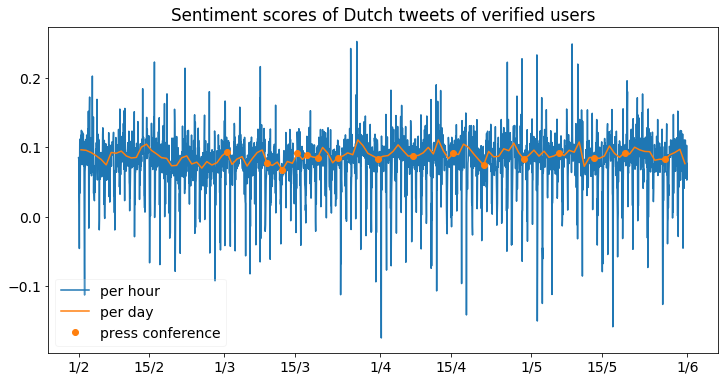

In [62]:
dummy = visualizeSentiment([{DATA:sentimentPerHour,LABEL:"per hour"},
                            {DATA:sentimentPerDay,LABEL:"per day",\
                             HIGHLIGHT:highlight,HIGHLIGHTLABEL:"press conference"}],\
                           title=DEFAULTTITLE)

In [59]:
pd.DataFrame.from_dict(sentimentPerHour).T.to_csv("sentiment-verified.csv",index_label="date")